In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))  # Add the project root to sys.path
import torch
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
#import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from utils.oct_dataset import OCTDataset
from utils.lossfunctions import DiceLoss
from utils.models import ResNetUNetWithAttention, MedSAM
from segment_anything import sam_model_registry
import torchmetrics

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def test_models(models_list, root_dir):
    # Define device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Initialize lists to store results
    model_names = []
    dice_coeffs = []
    image_ids = []
    model_outputs = []

    # Define dataset and transformations
    transform = transforms.Compose([
        transforms.Resize((1024, 1024), interpolation=Image.NEAREST),
        transforms.ToTensor(),
    ])

    test_dataset = OCTDataset(root_dir + "/data_gentuity",
        transform=transform,
        train=False,
        is_gentuity=True,
    )
    test_loader = DataLoader(torch.utils.data.Subset(test_dataset, range(2)), batch_size=1, shuffle=False, num_workers=0)

    # Define loss function
    criterion = DiceLoss()

    # Loop through models and test each one
    for model_name, model_config in models_list:
        print(f"Testing model: {model_name}")

        # Initialize the model
        if model_config["model"] == "Unet":
            net = smp.Unet(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "DeepLabV3+":
            net = smp.DeepLabV3Plus(
                encoder_name="resnet50",
                encoder_weights="imagenet",
                in_channels=3,
                classes=1,
            )
        elif model_config["model"] == "MedSam":
            sam_model = sam_model_registry['vit_b'](checkpoint=model_config["checkpoint_path"])
            net = MedSAM(
                image_encoder=sam_model.image_encoder,
                mask_decoder=sam_model.mask_decoder,
                prompt_encoder=sam_model.prompt_encoder,
            )
        elif model_config["model"] == "AttentionUnet":
            net = ResNetUNetWithAttention()

        # Load model checkpoint
        if model_config["model"] != "MedSam":
            checkpoint_path = model_config["checkpoint_path"]
            model_state, optimizer_state = torch.load(checkpoint_path, weights_only=True, map_location=torch.device('cpu'))
            net.load_state_dict(model_state)
        
        net.to(device)
        net.eval()

        # Test the model
        model_dice_scores = []
        total_loss = 0  # Accumulate loss for logging

        with torch.no_grad():  # Disable gradient calculation
            for image_id, data in enumerate(test_loader):
                if model_config["model"] == "MedSam":
                    # For MedSAM, process with bounding boxes
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    # Get image dimensions
                    batch_size, _, height, width = images.size()

                    # Create bounding boxes covering the entire image
                    bboxes = torch.tensor([[0, 0, width, height]] * batch_size, dtype=torch.float32).unsqueeze(1).to(device)

                    # Predict outputs with bounding boxes
                    outputs = net(images, bboxes)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()
                else:
                    # For other models
                    images, masks, _, _ = data
                    images, masks = images.to(device), masks.to(device)

                    outputs = net(images)
                    outputs = torch.sigmoid(outputs)
                    predicted = (outputs > 0.5).float()

                # Calculate loss dice score from torchmetrics
                dice_metric = torchmetrics.Dice().to(device)
                dice_score = dice_metric(predicted, masks.int())
                
                model_dice_scores.append(dice_score.item())
                print(f"Dice score: {dice_score.item():.4f}")

                # Store outputs for visualization
                model_outputs.append((images[0].cpu(), masks[0].cpu(), predicted[0].cpu(), model_name, dice_score.item()))

                print(f"Progress: {len(model_dice_scores)} / {len(test_loader)}", end="\r")

                # If 10 images, break
                if len(model_dice_scores) == 5:
                    break

        # Store results
        model_names.extend([model_name] * len(model_dice_scores))
        dice_coeffs.extend(model_dice_scores)

        print(f"{model_name} - Average Dice accuracy: {sum(model_dice_scores) / len(model_dice_scores):.4f}")




    return model_names, dice_coeffs, model_outputs, test_loader



In [32]:
# Run the function to get Dice scores and model names
root_dir = r"C:\Users\rasmu\OneDrive - Aarhus universitet\Deep Learning"

models_list = [
    ("MedSAM Frozen", {"model": "MedSam", "checkpoint_path": root_dir + "/checkpoints_second_training/medsam_frozen_bs=6_dicebce.pth"}),
    ("AttentionUnet Frozen", {"model": "AttentionUnet", "checkpoint_path": root_dir + "/checkpoints_second_training/attentionUnet_frozen_bs=6_dicebce.pt"}),
    ("U-Net Frozen", {"model": "Unet", "checkpoint_path": root_dir + "/checkpoints_second_training/unet_frozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ Frozen", {"model": "DeepLabV3+", "checkpoint_path": root_dir + "/checkpoints_second_training/deeplab_frozen_bs=6_dicebce.pt"}),
    ("MedSAM UnFrozen", {"model": "MedSam", "checkpoint_path": root_dir + "/checkpoints_second_training/medsam_unfrozen_bs=6_dicebce.pth"}),
    ("AttentionUnet UnFrozen", {"model": "AttentionUnet", "checkpoint_path": root_dir + "/checkpoints_second_training/attentionUnet_unfrozen_bs=6_dicebce.pt"}),
    ("U-Net UnFrozen", {"model": "Unet", "checkpoint_path": root_dir + "/checkpoints_second_training/unet_unfrozen_bs=6_dicebce.pt"}),
    ("DeepLabV3+ UnFrozen", {"model": "DeepLabV3+", "checkpoint_path": root_dir + "/checkpoints_second_training/deeplab_unfrozen_bs=6_dicebce.pt"}),
]


#save_dir = root_dir + "/output_images"  # Directory to save images with predictions
#os.makedirs(save_dir, exist_ok=True)

model_names, dice_coeffs, model_outputs, test_loader = test_models(models_list, root_dir)

Testing model: MedSAM Frozen


c:\Users\rasmu\anaconda3\envs\DL\Lib\site-packages\segment_anything\build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=t

Dice score: 0.9462
Dice score: 0.9666
MedSAM Frozen - Average Dice accuracy: 0.9564
Testing model: AttentionUnet Frozen
Dice score: 0.9644
Dice score: 0.9717
AttentionUnet Frozen - Average Dice accuracy: 0.9680
Testing model: U-Net Frozen
Dice score: 0.9588
Dice score: 0.9067
U-Net Frozen - Average Dice accuracy: 0.9328
Testing model: DeepLabV3+ Frozen
Dice score: 0.9721
Dice score: 0.9525
DeepLabV3+ Frozen - Average Dice accuracy: 0.9623
Testing model: MedSAM UnFrozen
Dice score: 0.9759
Dice score: 0.9723
MedSAM UnFrozen - Average Dice accuracy: 0.9741
Testing model: AttentionUnet UnFrozen
Dice score: 0.9566
Dice score: 0.9529
AttentionUnet UnFrozen - Average Dice accuracy: 0.9547
Testing model: U-Net UnFrozen
Dice score: 0.9677
Dice score: 0.8979
U-Net UnFrozen - Average Dice accuracy: 0.9328
Testing model: DeepLabV3+ UnFrozen
Dice score: 0.9743
Dice score: 0.9500
DeepLabV3+ UnFrozen - Average Dice accuracy: 0.9621


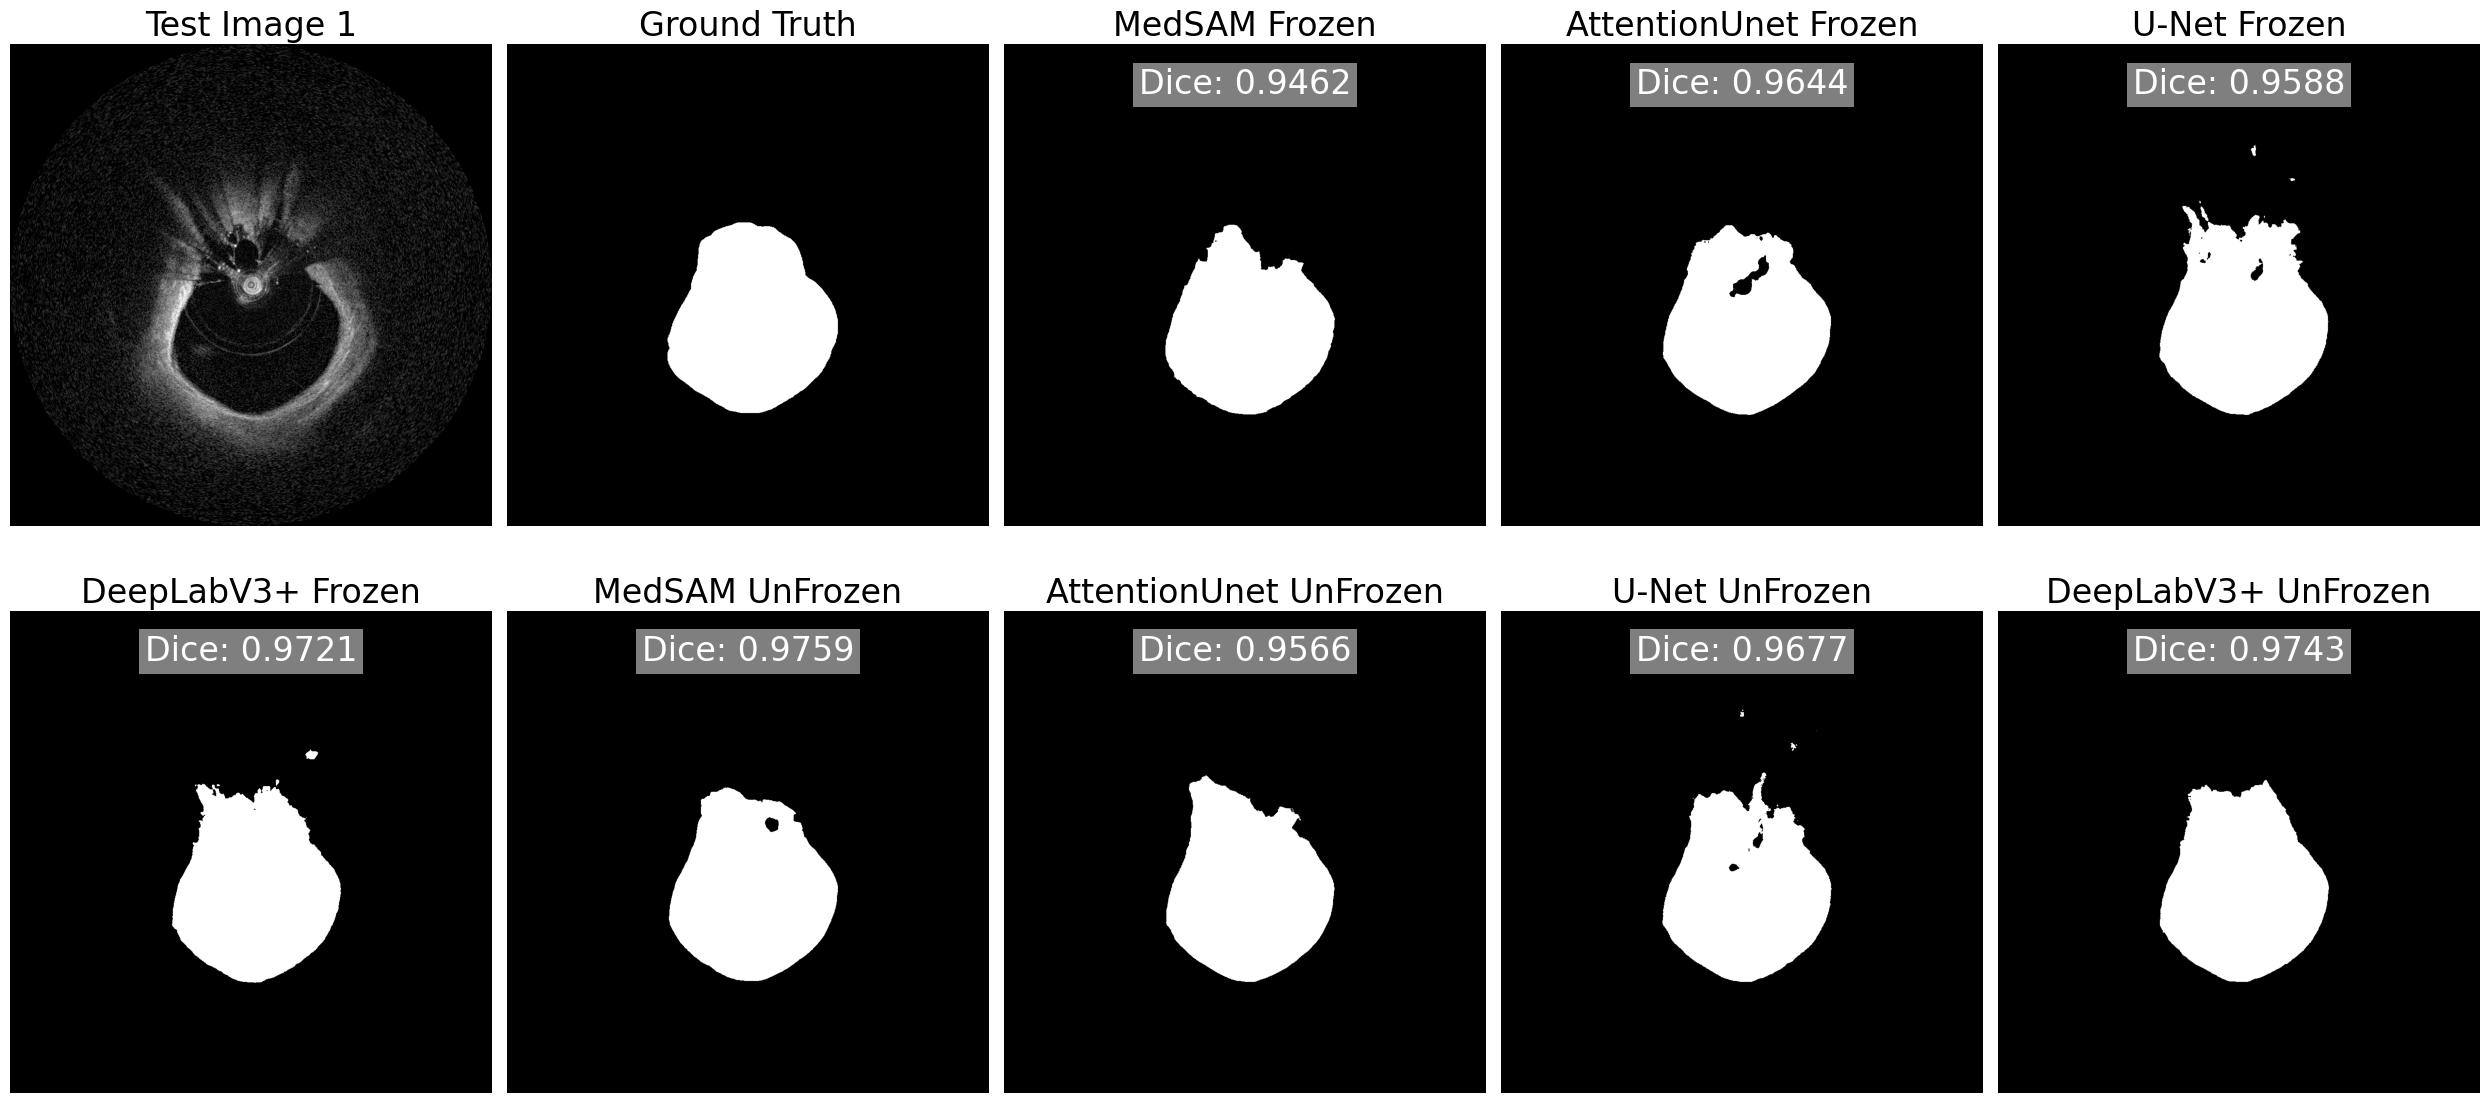

In [38]:
# Organize predictions by image index
outputs_by_image = {}
for i, (image, ground_truth, prediction, model_name, dice_score) in enumerate(model_outputs):
    image_index = i % len(test_loader)  # Determine which image this output corresponds to
    if image_index not in outputs_by_image:
        outputs_by_image[image_index] = {"image": image, "ground_truth": ground_truth, "predictions": []}
    outputs_by_image[image_index]["predictions"].append((prediction, model_name, dice_score))

# Only use the first image (image_index = 0) for visualization
first_image_data = outputs_by_image[0]

# Total slots required: Test Image + Ground Truth + Predictions
total_slots = 2 + len(models_list)

# Set up 2 rows and 4 columns
rows, cols = 2, 5

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 6 * rows))
axes = axes.flatten()  # Flatten axes for easier indexing

# Plot data for the first image
image = first_image_data["image"].permute(1, 2, 0).numpy()  # Convert to [H, W, C]
ground_truth = first_image_data["ground_truth"].permute(1, 2, 0).numpy()

# Add the first slot: Test Image
axes[0].imshow(image, cmap="gray" if image.shape[-1] == 1 else None)
axes[0].set_title("Test Image 1").set_size(24)
axes[0].axis("off")

# Add the second slot: Ground Truth
axes[1].imshow(ground_truth, cmap="gray")
axes[1].set_title("Ground Truth").set_size(24)
axes[1].axis("off")

# Add remaining slots: Predictions from models
for i, (prediction, model_name, dice_score) in enumerate(first_image_data["predictions"]):
    prediction = prediction.permute(1, 2, 0).numpy()
    ax_index = i + 2  # Start from the third slot
    if ax_index >= len(axes):
        break  # Ensure we don't exceed subplot limits

    axes[ax_index].imshow(prediction, cmap="gray")
    axes[ax_index].set_title(f"{model_name}").set_size(24)
    axes[ax_index].axis("off")

    # Add Dice score as text inside the image
    axes[ax_index].text(
        0.5, 0.95, f"Dice: {dice_score:.4f}",
        color="white", fontsize=24, ha="center", va="top",
        transform=axes[ax_index].transAxes,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')  # Optional background
    )

# Hide any unused subplots
for ax in axes[total_slots:]:
    ax.axis("off")

plt.tight_layout()
plt.show()




In [8]:
torch.cuda.empty_cache()

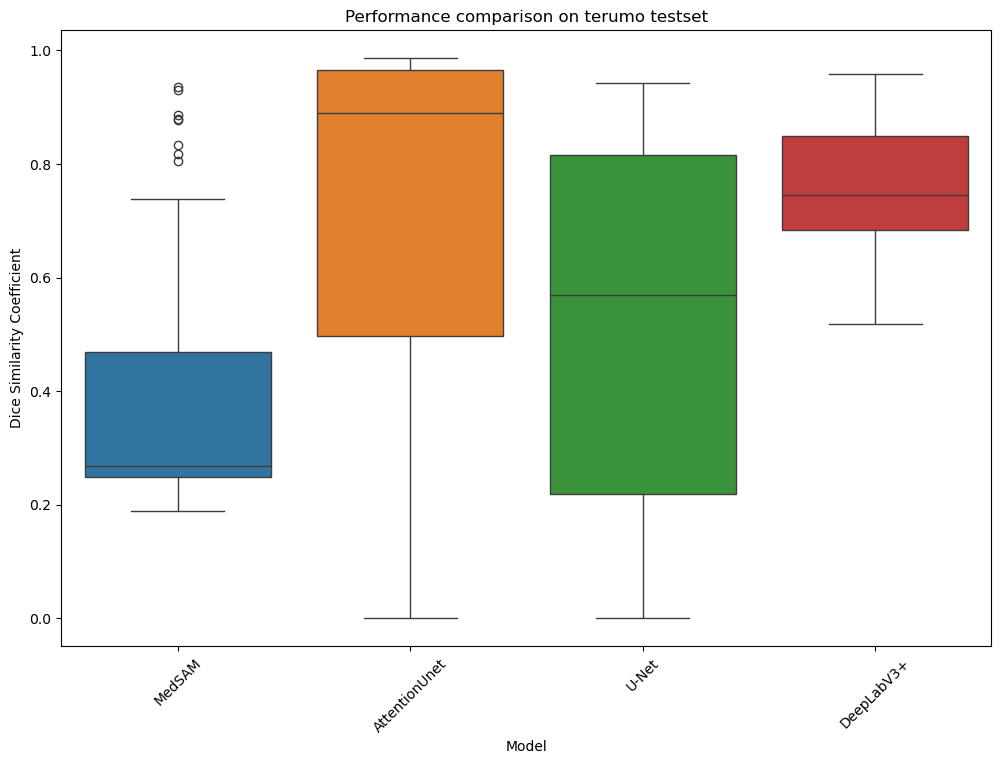

In [ ]:
# Create a DataFrame for visualization
results_df = pd.DataFrame({
    "Model": model_names,
    "Dice Score": dice_coeffs,
})

# Save the results to a csv file containing the model names and dice scores, and image_ids
results_df.to_csv("results_test_terumo.csv", index=False)


# Generate a boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x="Model", y="Dice Score", data=results_df, hue="Model", legend=False, showfliers=False)
plt.title("Performance comparison on terumo testset")
plt.ylabel("Dice Similarity Coefficient")
plt.xticks(rotation=45)
plt.show()

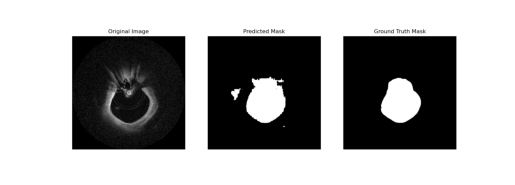

In [9]:
# Show saved image with predictions
# Open the image
image_path = "output_images/0_prediction_MedSAM.png"
image = Image.open(image_path)

# Display inline in the notebook
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()  # Display the image inline


In [9]:
# Load the .pth file
checkpoint_unfrozen = torch.load(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\unfrozen_test.pth", map_location=torch.device('cpu'))
checkpoint_frozen = torch.load(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\frozen_test.pth", map_location=torch.device('cpu'))


C:\Users\johan\AppData\Local\Temp\ipykernel_14788\1153418428.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_unfrozen = torch.load(r"D:\OneDrive - Aarhus Univ

In [11]:
# Extract mask_encoder from checkpoint_frozen and checkpoint_unfrozen
mask_encoder_frozen = {k: v for k, v in checkpoint_frozen["model"].items() if 'mask_decoder' in k}
mask_encoder_unfrozen = {k: v for k, v in checkpoint_unfrozen["model"].items() if 'mask_decoder' in k}

print("Mask Encoder Frozen Keys:", mask_encoder_frozen.keys())
print("Mask Encoder Unfrozen Keys:", mask_encoder_unfrozen.keys())

Mask Encoder Frozen Keys: dict_keys(['mask_decoder.transformer.layers.0.self_attn.q_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.q_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.k_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.k_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.v_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.v_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.out_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.out_proj.bias', 'mask_decoder.transformer.layers.0.norm1.weight', 'mask_decoder.transformer.layers.0.norm1.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.weight', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.weight', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.v_proj.weight', 

In [20]:
# Load the .pth file
checkpoint_unfrozen_bad = torch.load(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\checkpoints\checkpoint.pth", map_location=torch.device('cpu'))
checkpoint_frozen_bad = torch.load(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\checkpoints\medsam_frozen_bs=6_dicebce.pth", map_location=torch.device('cpu'))

C:\Users\johan\AppData\Local\Temp\ipykernel_14788\1975766080.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_unfrozen_bad = torch.load(r"D:\OneDrive - Aarhus 

In [13]:
# Extract mask_encoder from checkpoint_frozen and checkpoint_unfrozen
mask_encoder_frozen = {k: v for k, v in checkpoint_frozen["model"].items() if 'mask_decoder' in k}
mask_encoder_unfrozen = {k: v for k, v in checkpoint_unfrozen["model"].items() if 'mask_decoder' in k}

print("Mask Encoder Frozen Keys:", mask_encoder_frozen.keys())
print("Mask Encoder Unfrozen Keys:", mask_encoder_unfrozen.keys())

Mask Encoder Frozen Keys: dict_keys(['mask_decoder.transformer.layers.0.self_attn.q_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.q_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.k_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.k_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.v_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.v_proj.bias', 'mask_decoder.transformer.layers.0.self_attn.out_proj.weight', 'mask_decoder.transformer.layers.0.self_attn.out_proj.bias', 'mask_decoder.transformer.layers.0.norm1.weight', 'mask_decoder.transformer.layers.0.norm1.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.weight', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.q_proj.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.weight', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.k_proj.bias', 'mask_decoder.transformer.layers.0.cross_attn_token_to_image.v_proj.weight', 

In [18]:
sam_model = sam_model_registry['vit_b'](checkpoint=r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\medsam\medsam_vit_b.pth")
sam_checkpoint = torch.load(r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\medsam\medsam_vit_b.pth", map_location=torch.device('cpu'))

c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\segment_anything\build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=t

In [19]:
checkpoint_path = r"D:\OneDrive - Aarhus Universitet\9. Semester\Deep Learning\unfrozen_test2.pth"
sam_model = sam_model_registry['vit_b'](checkpoint=checkpoint_path)
net = MedSAM(
    image_encoder=sam_model.image_encoder,
    mask_decoder=sam_model.mask_decoder,
    prompt_encoder=sam_model.prompt_encoder,
)


c:\Users\johan\anaconda3\envs\dl\Lib\site-packages\segment_anything\build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=t